# System identification including a time variable

## Introduction

In this we want to study how including a time variable in our dynamics will change the identification. Our goal is to find a function $f$ so that the the number of cumulative cases in a given country $\mathbf{x}$ verifies the following ODE: 

$$\mathbf{x}_{t+1} = f(\mathbf{x}_t, t)$$

The idea behind this model is that the systems that we study include lots of time-dependent characteristics. For example, modeling the COVID evolutions with a simple SIR model without time-dependent parameters gives very poor results while having an $R_0$ value with just three different values as a staircase function gives much better fitting. 

## Implementation


We just add a variable $t$ to the system of variables so that our state is $\mathbf{x_t} = (x_t, t)$ and our observed data becomes:

$$X = 
\begin{bmatrix}
x_0 & 0 \\
x_1 & 1 \\
x_2 & 2 \\
\vdots & \vdots\\
x_m & m
\end{bmatrix}
$$

In this setting, if we use polynomial terms as candidate functions we will have the following kind of terms $(1, x, t, x^2, xt, t^2, x^3, x^2t, \dots)$

## First results







In [2]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from tqdm import tqdm
import ipywidgets as widgets
%load_ext autoreload

In [3]:
%autoreload
import codebase
from codebase.sparse_regression import *
from codebase.utils import *


dataset = CountryDataset()

In [4]:
country = "Italy"

country_data = dataset.cumulative(country, rescaling=-1)
country_data = country_data[country_data > 0.001].reshape(-1, 1)

m2, m1 = make_targets(country_data)

m1 = np.c_[m1, np.arange(0, len(m1))]

augmented, _ = make_polynomials(m1, max_degree=(max_degree:=3))

weights, _ = sparse_regression(augmented, m2, cutoff=2e-4)

show_weights(weights, variables=['1', '\mathbf{x}', 't'])

| function        |   $\mathbf{x}_{k+1}$ |
|:----------------|---------------------:|
| $1$             |         -0.00174033  |
| $ \mathbf{x}$   |          1.12141     |
| $ \mathbf{x}^2$ |          0.000689095 |
| $ \mathbf{x}^3$ |         -0.0840088   |
| $ \mathbf{x}^4$ |         -0.00358322  |
| $ \mathbf{x}^5$ |          0           |
| $ \mathbf{x}^6$ |          0           |

In [7]:
results = {}

for country in dataset.all_hopkins_countries(cases_cap=2000):

    country_data = dataset.cumulative(country, rescaling=-1)
    country_data = country_data[country_data > 0.001].reshape(-1, 1)

    m2, m1 = make_targets(country_data)

    m3 = np.c_[m1, np.arange(0, len(m1))]

    augmented3, _ = make_polynomials(m3, max_degree=(max_degree:=3))
    weights3, _ = sparse_regression(augmented3, m2, cutoff=2e-4)
    
    augmented, _ = make_polynomials(m1, max_degree=(max_degree:=3))
    weights, _ = sparse_regression(augmented, m2, cutoff=2e-4)
    
    results[country] = {'data': country_data.flatten().tolist(),
                        'dependent': weights3.numpy().flatten().tolist(),
                        'independent': weights.numpy().flatten().tolist()}
    

import json

with open('data/time-dependent.json', 'w') as f:
    json.dump(results, f)

[]

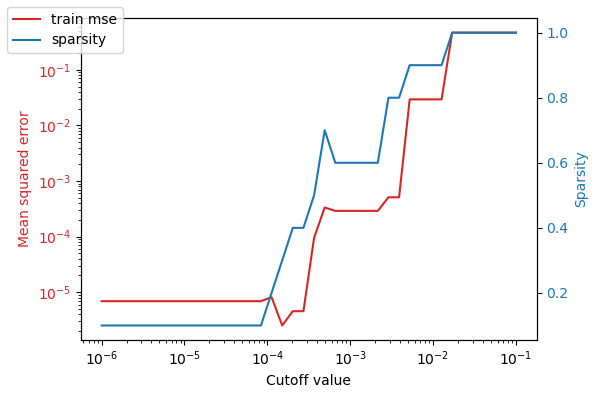

In [13]:
%autoreload

rest = cutoff_mses(augmented, m2, -6, -1)

fig, ax1 = plt.subplots(dpi=100)

color = 'tab:red'
ax1.set_xlabel('Cutoff value')
ax1.set_ylabel('Mean squared error', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.plot(rest['cutoffs'], rest['mses'], color=color, label='train mse')
ax1.tick_params(axis='y')

handles, labels = ax1.get_legend_handles_labels()

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Sparsity', color=color)
ax2.plot(rest['cutoffs'], rest['sparsity'], color=color, label='sparsity')
ax2.set_xscale('log')
ax2.tick_params(axis='y', labelcolor=color)
handles2, labels2 = ax2.get_legend_handles_labels()
handles += handles2
labels += labels2

fig.legend(handles, labels, loc='upper left')

fig.tight_layout()
plt.plot()

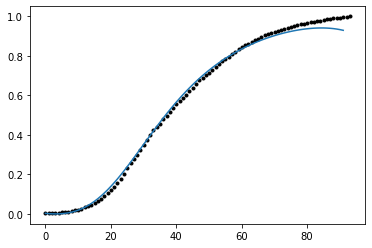

In [14]:
def integrate_here(weights, initial_position, length, max_degree=3):
    result = np.zeros((length, 2))
    result[0] = initial_position
    for i, d in enumerate(result[:-1]):
        a, _ = make_polynomials(d, max_degree=max_degree)
        n = a.reshape(1, -1) @ weights
        result[i + 1, 0] = n
        result[i + 1, 1] = result[i, 1] + 1
    return result




guess = integrate_here(weights, m1[0], len(m1), max_degree=max_degree)
plt.plot(country_data, 'k.')
plt.plot(guess[:, 1], guess[:, 0])

<ipython-input-15-d44be8b8c9ec>:25: RuntimeWarning: invalid value encountered in greater
  guess[:, 0][(guess[:, 0] > 2) | (guess[:, 0] < -0.5)] = np.nan
<ipython-input-15-d44be8b8c9ec>:25: RuntimeWarning: invalid value encountered in less
  guess[:, 0][(guess[:, 0] > 2) | (guess[:, 0] < -0.5)] = np.nan


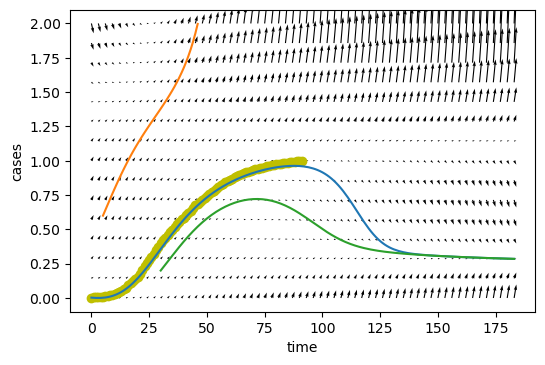

In [15]:
T = np.arange(0, len(m1)*2, 3)
C = np.linspace(0, 2, 15)

U, V = np.zeros((len(C), len(T))), np.zeros((len(C), len(T))),

for i, t in enumerate(T):
    for j, c in enumerate(C):
        a, _ = make_polynomials(np.c_[c, t], max_degree=max_degree)
        
        U[j, i] = 0.01
        V[j, i] = (a.reshape(1, -1) @ weights - c)/2


fig, ax = plt.subplots(dpi=100)
q = ax.quiver(T, C, U, V)
# ax.quiverkey(q, X=1, Y=1, U=10,
#              label='Quiver key, length = 10', labelpos='E')


ax.plot(m2, 'yo')
guess = integrate_here(weights, m2[0], len(m2)*2, max_degree=max_degree)
guess[:, 0][(guess[:, 0] > 2) | (guess[:, 0] < -0.5)] = np.nan
ax.plot(guess[:, 1], guess[:, 0])
guess = integrate_here(weights, [0.6, 5], len(m2) - 5, max_degree=max_degree)
guess[:, 0][(guess[:, 0] > 2) | (guess[:, 0] < -0.5)] = np.nan
ax.plot(guess[:, 1], guess[:, 0])
guess = integrate_here(weights, [0.2, 30], len(m2)*2 - 30, max_degree=max_degree)
guess[:, 0][(guess[:, 0] > 2) | (guess[:, 0] < -0.5)] = np.nan
ax.plot(guess[:, 1], guess[:, 0])
ax.set_xlabel('time')
ax.set_ylabel('cases')
plt.show()

| function        |   $\mathbf{x}_{k+1}$ |
|:----------------|---------------------:|
| $1$             |            0.0045425 |
| $ \mathbf{x}$   |            1.11968   |
| $ \mathbf{x}^2$ |           -0.220779  |
| $ \mathbf{x}^3$ |            0.0996065 |

<ipython-input-8-6b09eaeacf04>:37: RuntimeWarning: invalid value encountered in greater
  guess[(guess > 2) | (guess < -0.5)] = np.nan
<ipython-input-8-6b09eaeacf04>:37: RuntimeWarning: invalid value encountered in less
  guess[(guess > 2) | (guess < -0.5)] = np.nan


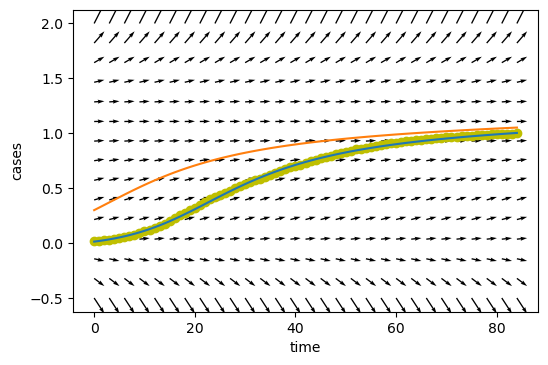

In [8]:
country_data = dataset.cumulative(country, rescaling=-1)
country_data = country_data[country_data > 0.01].reshape(-1, 1)

m2, m1 = make_targets(country_data)

augmented, _ = make_polynomials(m1, max_degree=max_degree)

weights, _ = sparse_regression(augmented, m2, cutoff=1e-5)

show_weights(weights, variables=['1', '\mathbf{x}', 't'])

T = np.arange(0, len(m1), 3)
C = np.linspace(-0.5, 2, 15)

U, V = np.zeros((len(C), len(T))), np.zeros((len(C), len(T))),

for i, t in enumerate(T):
    for j, c in enumerate(C):
        a, _ = make_polynomials(np.array([c]), max_degree=max_degree)
        U[j, i] = 0.04
        V[j, i] = (a.reshape(1, -1) @ weights - c)/2


fig, ax = plt.subplots(dpi=100)
q = ax.quiver(T, C, U, V)
# ax.quiverkey(q, X=1, Y=1, U=10,
#              label='Quiver key, length = 10', labelpos='E')

ax.plot(m2, 'yo')
guess = integrate(weights, m1[0], range(len(m1)))
guess[(guess > 2) | (guess < -0.5)] = np.nan
ax.plot(guess)
guess = integrate(weights, [0.3], range(len(m1)))
guess[(guess > 2) | (guess < -0.5)] = np.nan
ax.plot(guess)
guess = integrate(weights, [1.9], range(len(m1)))
guess[(guess > 2) | (guess < -0.5)] = np.nan
ax.plot(guess)
ax.set_xlabel('time')
ax.set_ylabel('cases')
plt.show()

In [16]:
weights.numpy().flatten().tolist()

[-0.001737720682285726,
 1.1234612464904785,
 0.0006858287379145622,
 -0.08383361250162125,
 -0.003659510286524892,
 0.0,
 0.0,
 0.0025732512585818768,
 0.0,
 0.0]

In [18]:
country_data.flatten()

array([0.00138954, 0.00195484, 0.00282654, 0.00383201, 0.00486769,
       0.00731017, 0.00878601, 0.01079696, 0.01333005, 0.01664854,
       0.02000587, 0.02538709, 0.03182556, 0.0395802 , 0.04379628,
       0.05377764, 0.06521758, 0.07620872, 0.09129943, 0.10679147,
       0.12074293, 0.13595878, 0.15411337, 0.17707956, 0.20291112,
       0.23120674, 0.25519997, 0.27586609, 0.29851725, 0.32100012,
       0.34776811, 0.3732674 , 0.39904718, 0.42156025, 0.43903734,
       0.45652737, 0.47716327, 0.49730723, 0.51709302, 0.53782818,
       0.55645314, 0.57198402, 0.5850983 , 0.60165191, 0.61979355,
       0.63684342, 0.65709958, 0.67475791, 0.68836414, 0.7011893 ,
       0.71269829, 0.72903613, 0.74410957, 0.75917439, 0.7723232 ,
       0.78205858, 0.79383512, 0.80837778, 0.81979614, 0.83283276,
       0.84300399, 0.85303281, 0.86053717, 0.86956053, 0.8785623 ,
       0.8866406 , 0.89512023, 0.90331935, 0.90931334, 0.91458236,
       0.91922134, 0.92545268, 0.93149846, 0.9372249 , 0.94189